In [1]:
from Engine.Broker import Broker
from Engine.Orders import MKT, LMT, TRAIL_LMT, ADAPT
from Engine.Statistics import Statistics
from Engine.Exchange import Exchange

import pandas as pd
import pandas_ta as ta

In [24]:
class Algos:
    def __init__(self, num):
        self.num = num
        self.__setup_func = getattr(self, f'setup{num}')
        self.__algo_func = getattr(self, f'algo{num}')
    
    def setup0(self, df):
        return df

    def algo0(self, **var):
        return None

    def setup1(self, df):
        df["small_rolling"] = ta.sma(df["close"], 20)
        df["long_rolling"] = ta.sma(df["close"], 200)
        self.bought = False
        return df
    
    def algo1(self, **var):
        """
        Golden Crossover
        """
        if var["new_stock"]:
            self.bought = False
        
        if var["shares"] > 0 or self.bought:
            return None

        row = var["current_tick"]
        rol_small, rol_long = row["small_rolling"], row["long_rolling"]
        
        # Buy
        if var["shares"] <= 0 and rol_small > rol_long:
            # -1 for good measure
            shares = int((var["balance"] // var["price"]) - 1)
            buy_order = LMT(shares, var["price"])
            
            # Risk managment
            risk = var["initial_day_balance"] * 0.02
            sell_order = TRAIL_LMT(shares, price_delta=-(risk / shares))
            self.bought = True
            return [buy_order, sell_order]

        return None
            


    def send_setup(self, df):
        """
        Add columns/indicators to calculate before the run in order to save time

        Inputs
        :df (pd.DataFrame) The DataFrame containing OHLC (Open, High, Low, Close), Adj Close and Volume

        Output
        :df (pd.DataFrame) Same DataFrame with more columns and/or indicators
        """
        return self.__setup_func(df)

    def send_algo(self, **var):
        """
        Get values from the environment

        Inputs (var)
        :df (pd.DataFrame)            The DataFrame containing all values upto current bar
        :current_tick (dict)          Current bar and it's fields
        :price (float)                'close' field from current bar in df
        :initial_day_balance (float)  Money in the account at the beginning of the day
        :balance (float)              Cash spendable
        :bought_market_value (float)  market_value at time of last buy (shares * price)
        :market_value(float)          Shares * Price
        :shares (integer)             Position    
        :new_stock (bool)             True if it is the start of a file

        Output
        :Order (class) An order class from Engine/Orders.py
        """
        return self.__algo_func(**var)


def print_output(results):
    for key in results.keys():
        print(f"{key}".title().ljust(15, " ") + f": {results[key]}")
    print()

Algorithm = Algos("1")

filepath = "Data/intraday_trading/"

exchange_feed = Exchange(
    filepath=filepath,
    limit=-1,
    lazy_loading=True,
    lazy_loading_limit=5,
    slippage=1)

broker = Broker(
    cash=5000,
    algorithm=Algorithm,
    trade_cost=2,
    info=False,
    warnings=False,
    progress=True,
    exchange_feed=exchange_feed)

broker.simulate()
results = broker.get_results()

print("BASIC RESULTS")
print_output(results)

BASIC RESULTS
Initial Cash   : 5000
Final Cash     : 5483.15
Time Taken     : 1.03
Candles/Second : 32465.42



EXTRA INFORMATION
%Mean          : 0.1348
Sortino        : 4.473



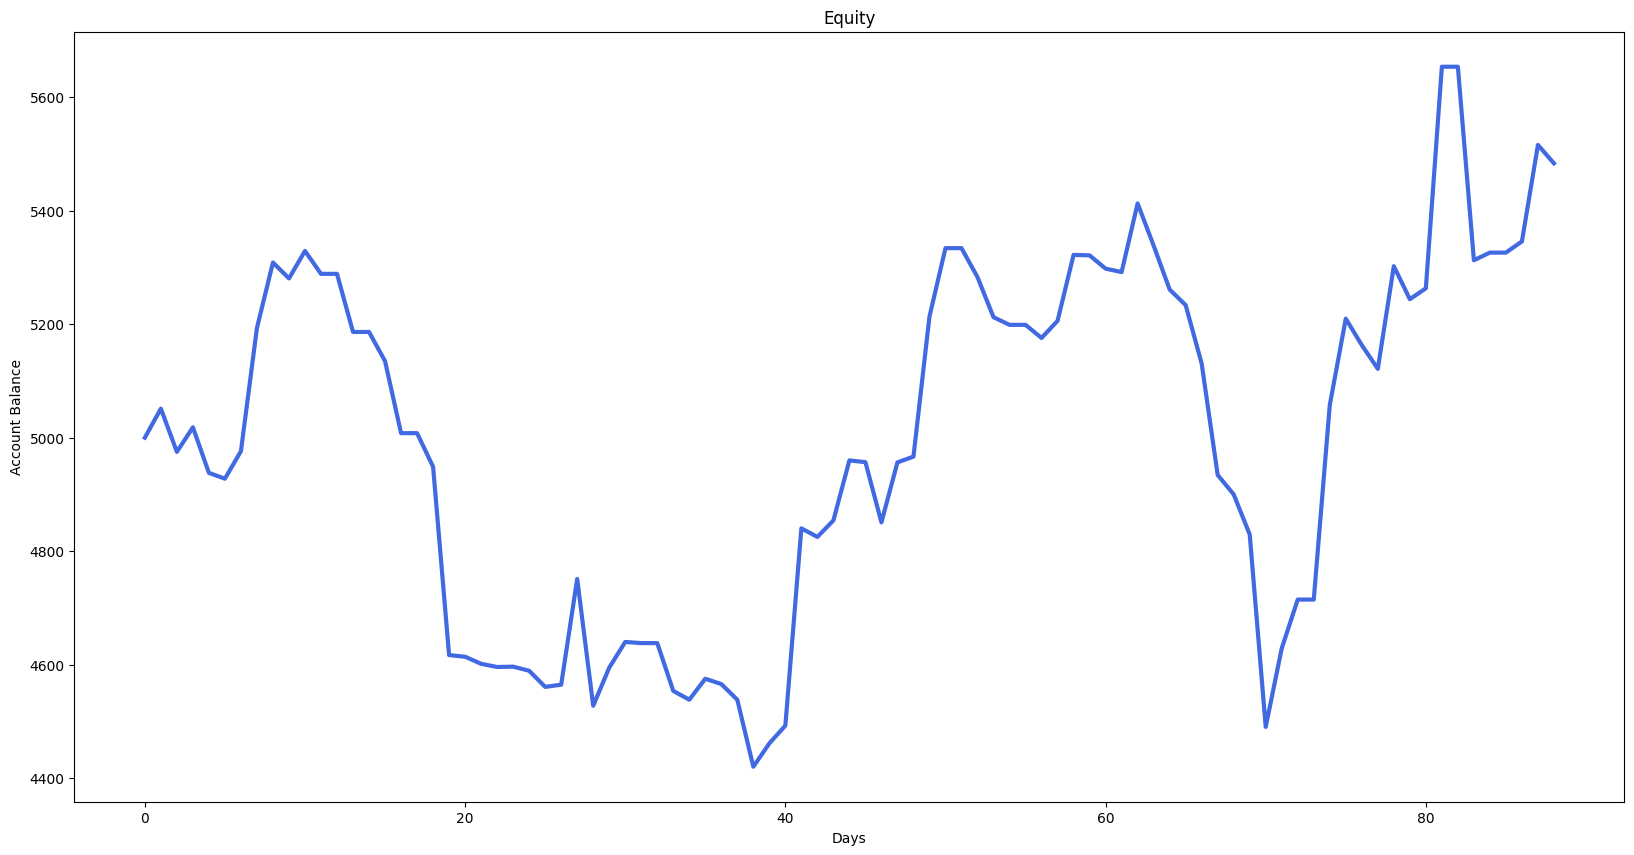

[80]


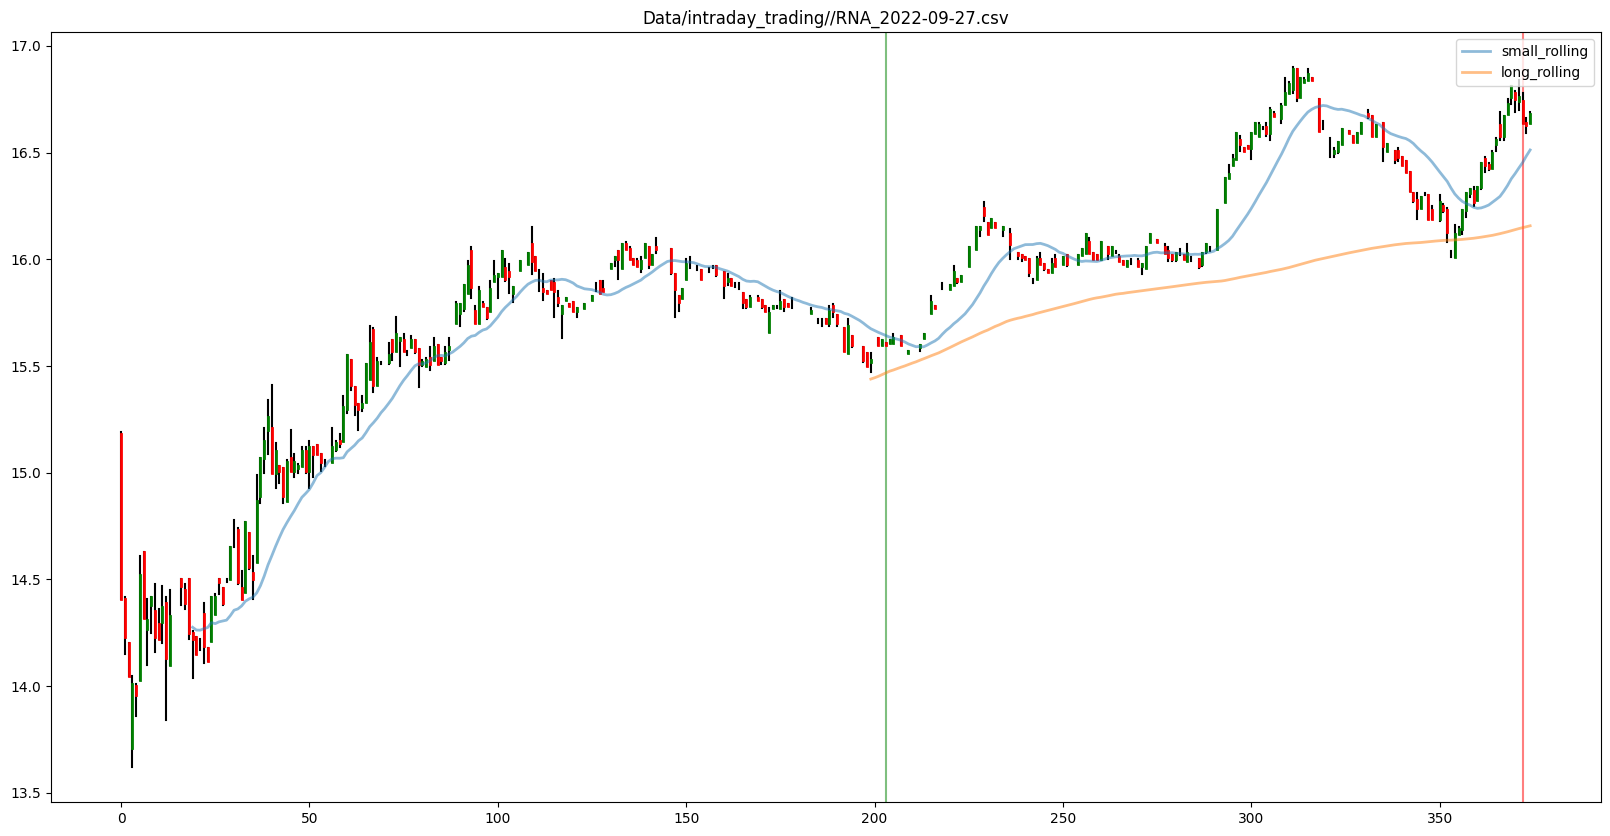

In [25]:
statistics = Statistics(broker)

print("EXTRA INFORMATION")
print_output(statistics.get_statistics())

statistics.cash_graph("linear")

outliers = statistics.get_outliers()
print(outliers)
statistics.plot_sub_file_trades(outliers, include=["small_rolling", "long_rolling"])